In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import json

model = YOLO('best.pt')

In [2]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rounding_up(matrix): # заменяет все числа на 1 и 0
    """
    массив, что содержит в себе все цвета каждого пикселя преобразует числа цветов в 1 и нолики (0 - чёрный цвет, а 1 - белый цвет)
    """
    result = np.zeros_like(matrix)
    result[matrix > 120] = 1
    return result

def split_matrix(matrix, rows, cols):
    """
    разделяет список на 25 частей (то есть разделяет весь массив, картинку на матрицу 5 на 5 клеток)
    """
    row_size, col_size = rows // 5, cols // 5
    parts = []
    for i in range(5):
        for j in range(5):
            part = matrix[i * row_size : (i + 1) * row_size, j * col_size : (j + 1) * col_size]
            parts.append(part)
    return parts

def replace_based_on_center(parts):
    """
    округляет каждую часть списка до 1 или 0 на основе цвета центрального пикселя
    """
    replaced_parts = []
    for part in parts:
        center_pixel = part[len(part) // 2, len(part[0]) // 2]
        replaced_part = np.full_like(part, center_pixel)
        replaced_parts.append(replaced_part)
    return replaced_parts

def combine_parts(rounded_parts):
    """
    сохраняет всё в виде матрицы 5 на 5, где каждая клетка равна либо положительному числу, либо нулю
    """
    combined_matrix = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            part_index = i * 5 + j
            combined_matrix[i, j] = 1 if np.sum(rounded_parts[part_index]) > 0 else 0
    return combined_matrix

def read_from_json(filename):
    # Открытие файла для чтения
    with open(filename, 'r') as json_file:
        # Загрузка данных из файла
        data = json.load(json_file)
    return data

def load_json_to_matrices(filename):
    """
    загрузка базы данных в список matrices и преобразование его в словарь numpy
    """
    with open(filename, 'r') as json_file:
        data = json.load(json_file)

    matrices = {}
    for key, value in data.items():
        matrices[key] = np.array(value)
    
    return matrices

def compare_matrices(matrix1, matrices_from_json):
    """
    сравнение нашей матрицы с матрицами из базы данных
    """
    for key, matrix2 in matrices_from_json.items():
        if np.array_equal(matrix1, matrix2):
            return key
    return None

def mainer(picture, json_file): 
    """
    Финальная функция, что содержит в себе все предыдущие. main возвращает номер карточки и вариант её ответа, если же данная картачка не
    совпадает ни с одной из карточек из базы данных, то возвращается None. (Принимает на вход саму картинку и файл с базой данных)
    """
    cb_img = picture
    cb_img_np = np.array(cb_img)
    plt.imshow(cb_img_np, cmap='gray')
    _, cb_img_np = cv2.threshold(cb_img_np, 127, 255, 0)
    lines, columns = cb_img.shape
    the_converted_image = combine_parts(replace_based_on_center(split_matrix(rounding_up(cb_img_np), lines, columns)))
    return compare_matrices(the_converted_image, load_json_to_matrices(json_file))

In [3]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

In [4]:
def find_largest_contour(image):
    # Переводим изображение в оттенки серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Применяем пороговую обработку для получения бинарного изображения
    _, thresh = cv2.threshold(gray, 127, 255, 0)
    # Инвертируем бинарное изображение
    thresh = cv2.bitwise_not(thresh)
    # Находим контуры на инвертированном бинарном изображении
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Находим наибольший контур
    largest_contour = max(contours, key=cv2.contourArea)
    extreme_points = [(0, 0), (0, image.shape[0]), (image.shape[1], image.shape[0]),
                      (image.shape[1], 0)]  # Изначально углы изображения
    min_distances = [np.inf, np.inf, np.inf, np.inf]  # Изначально расстояния до углов
    # Перебор всех точек контура для поиска крайних
    for point in largest_contour:
        x, y = point[0][0], point[0][1]
        distances = [x, image.shape[0] - y, image.shape[1] - x, y]
        for i in range(4):
            if distances[i] < min_distances[i]:
                min_distances[i] = distances[i]
                extreme_points[i] = (x, y)
    return extreme_points

In [5]:
#функция вырезки карточек из изображения
def crop_images(img, coordinates):
    images = []
    # Применяем пороговую обработку для получения бинарного изображения
    for coords in coordinates:
        left, top, right, bottom = map(int, coords)
        cropped_img = img[top:bottom, left:right]
        images.append(cropped_img)
    return images

In [6]:
#функция поворота карточи на угол
def rotate_image(image, angle):
    # Получаем высоту и ширину изображения
    height, width = image.shape[:2]
    # Вычисляем центр поворота
    center = (width / 2, height / 2)
    # Поворачиваем изображение на заданный угол
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image


12C
9A


IndexError: index 0 is out of bounds for axis 0 with size 0

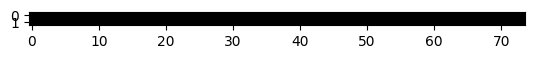

In [29]:
#Вывод варинтов ответа по карточкам из фотографии
def print_results_photo(img):
    answers=[]
    results=model(img)
    boxes = results[0].boxes.xyxy.cpu().tolist()
    images=crop_images(cv2.imread(img),boxes)
    for i in range(len(images)):
        image=images[i]
        image = cv2.copyMakeBorder(image, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        image=rotate_image(image,30)
        pts = np.array(find_largest_contour(image), dtype = "float32")
        warped = four_point_transform(image, pts)
        gray_image = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
        count=0
        while mainer(gray_image,'image_database.json')==None and count<8:
            image=rotate_image(image,-10)
            pts = np.array(find_largest_contour(image), dtype = "float32")
            warped = four_point_transform(image, pts)
            gray_image = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
            count+=1
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow("Original", image)
        cv2.imshow("Warped", gray_image)
        cv2.waitKey(0)
        print((mainer(gray_image,'image_database.json')))
    return answers
print_results_photo('100.jpg')
#96-идеал
#113-Ошибка
#109-ошибка
#107-ошибка
#100-ошибка


In [24]:
#Демонстрация работы нейросети на видео в реальном времени
def Real_time_demonstration():
    # Захватываем видеопоток с первой доступной веб-камеры
    cap = cv2.VideoCapture(0)

    while True:
        # Считываем кадр с веб-камеры
        ret, frame = cap.read()
        results = model(frame,verbose=False,conf=0.8)
        cv2.imshow('Webcam', results[0].plot())
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Освобождаем ресурсы
    cap.release()
    cv2.destroyAllWindows()

# Запускаем функцию для вывода видео с веб-камеры
Real_time_demonstration()

1B
1B
2D
1B
2D
2D
1B
1B
2D
3D
1B
2D
3D
2D
1B
3D
3D
1B
3D
2D
3D
1B
2D
1B
2D
1B
2D
1B
1B
2D
1B
2D
1B
1B
2D
2D
2D
2D
1B
2D
1B
2D
1B
2C
1A
2C
1A
2C
3C
1A
2C
3C
1A
2C
3C
1A
2C
3C
2C
1A
3C
2C
1A
3C
2C
1A
3C
2C
1A
2C
2C
1B
2D
1B
2D
1B
2D
2D
1B
1B
2D
2D
2D
2D
2D
2D


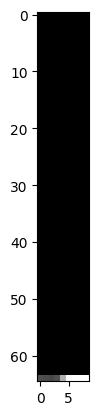

In [22]:
#Демонстрация работы нейросети + алгоритма распознования карточек в реальном времени
def Real_time_define():
    # Захватываем видеопоток с первой доступной веб-камеры
    cap = cv2.VideoCapture(0)

    while True:
        # Считываем кадр с веб-камеры
        ret, frame = cap.read()
        results = model(frame,verbose=False,conf=0.8)
        boxes = results[0].boxes.xyxy.cpu().tolist()
        images=crop_images(frame,boxes)
        for i in range(len(images)):
            image=images[i]
            image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])
            image=rotate_image(image,30)
            pts = np.array(find_largest_contour(image), dtype = "float32")
            warped = four_point_transform(image, pts)
            gray_image = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
            result=mainer(gray_image,'image_database.json')
            if result !=None:
                print(result)
        cv2.imshow('Webcam', results[0].plot())
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Освобождаем ресурсы
    cap.release()
    cv2.destroyAllWindows()
Real_time_define()